In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("project_134.ipynb")

# Final Project 
    
## PSTAT 134 (Winter 2024) 
    
## Collaboration Policy 

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

<!-- BEGIN QUESTION -->

## Question 1: Using Linear Algebra for Optimization
In recommender system module, low-rank matrix factorization was used to execute latent factor modeling of movie ratings data.

Specifically, we calculated matrices $U$ and $V$ to solve the following optimization problem (if all ratings were given):
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

The best $U$ and $V$ were calculated iteratively by improving on current estimates:
$$
\begin{aligned}
u_i^{\text{new}} &= u_i + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot v_m\\
v_m^{\text{new}} &= v_m + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot u_i,
\end{aligned}
$$
where $\alpha$ is the step-size that is to be chosen by the user, $i = 1,2,\ldots, I$, $m = 1,\ldots,M$. (We won't discuss the role of $\alpha$ in this class, but treat it as an arbitrary, but given, parameter) 

We can make calculating the updates more efficient by calculating them with matrix operations. For example, instead of calculating each deviation $\gamma_{mi} = r_{mi} - v_m u_i^T$ separately for all $m=1,2,\dots,M$ and $i=1,2,\dots,I$, matrix $\Gamma$ of all deviations can be computed together using matrix operation _(verify for yourself)_:
$$\Gamma = R - VU^T$$

Similarly, updating $U$ and $V$ can be combined into matrix calculations which makes the optimization procedure more efficient.

First, note that updates for $u_i$, $i=1,2,\dots,I$ can be rewritten as
$$
\begin{aligned}
u_1^{\text{new}} &= u_1 + 2\alpha D_{m1}\gamma_{m1}\cdot v_m\\
u_2^{\text{new}} &= u_2 + 2\alpha D_{m2}\gamma_{m2}\cdot v_m\\
\vdots\quad &\qquad\qquad\vdots\\
u_I^{\text{new}} &= u_I + 2\alpha D_{mI}\gamma_{mI}\cdot v_m.
\end{aligned}
$$
Stacking all $I$ equations into a matrix form, 
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha (D_{m-}\circ\Gamma_{m-})^T v_m,
\end{aligned}
$$
where $I_{m-}$ and $\Gamma_{m-}$ are the $m$-th row of $\Gamma$ and $D$ (use the notation $\Gamma_{-i}$ for the $i$-th column). Hadamard product (elementwise matrix product) is denoted with $\circ$. When evaluating $U^{\text{new}}$, the latest updated values of $U$, $V$, and $\Gamma$ are used.

Note that there are $M$ such update equations (one for each $m=1,2,\dots,M$) that can also be combined into one matrix update equation involving matrices $U$, $V$, $\Gamma$ and scalars. As stated earlier, since $\alpha$ is assumed to be an arbitrary step-size parameter, we can replace $\alpha/M$ with $\alpha$.

### Question 1a: Using Linear Algebra for Optimization

Complete the following update equations:
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha[\text{some function of }\Gamma][\text{some function of }V]\\
V^{\text{new}} &= V + 2\alpha[\text{some function of }\Gamma][\text{some function of }U]
\end{aligned}
$$

**SOLUTION**

$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha (D \circ \Gamma)^T V\\
V^{\text{new}} &= V + 2\alpha (D \circ \Gamma) U
\end{aligned}
$$

<!-- END QUESTION -->

### Question 1b: Implementing Updates

In this problem, you will implement the updates calculated in the previous problem. Define the following three functions:

* `update_G(R, U, V)`: computes deviation $R-VU^T$
* `update_U(G, U, V, alpha=0.01)`: calculates update $U^{\text{new}}$
* `update_V(G, U, V, alpha=0.01)`: calculates update $V^{\text{new}}$

Each function should only be one line of matrix operations. Three functions is to be applied sequentially, using the most up-to-date estimates of $G$, $U$, and $V$.

Since some elements of `R` are `np.nan` for any missing ratings, `update_U` and `update_V` functions need to be adjusted by using `numpy.nan_to_num` function where appropriate. The function `numpy.nan_to_num` will let you replace `NaN` to some number, so that missing ratings do not interfere with updates.

In [43]:
import numpy as np
import pandas as pd
import altair as alt
alt.renderers.enable('mimetype')

def update_G(R_, U_, V_):
    
    return R_ - np.dot(V_, U_.T)

def update_U(G_, U_, V_, alpha=0.01):
    
    return U_ + 2 * alpha * np.dot(np.nan_to_num(G_.T), V_)

def update_V(G_, U_, V_, alpha=0.01):
    
    return V_ + 2 * alpha * np.dot(np.nan_to_num(G_), U_)

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G(R_, U_, V_)

In [3]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

But, first, here are functions that will calculate RMSE and quantify the maximum update (in absolute value) made by `update_U` and `update_V` after they are called.

In [4]:
def rmse(X):
    """
    Computes root-mean-square-error, ignoring nan values
    """
    return np.sqrt(np.nanmean(X**2))

def max_update(X, Y, relative=True):
    """
    Compute elementwise maximum update
    
    parameters:
    - X, Y: numpy arrays or vectors
    - relative: [True] compute relative magnitudes
    
    returns
    - maximum difference between X and Y (relative to Y) 
    
    """
    if relative:
        updates = np.nan_to_num((X - Y)/Y)
    else:
        updates = np.nan_to_num(X - Y)
            
    return np.linalg.norm(updates.ravel(), np.inf)

A template for the optimization algorithm is given below. Fill-in the missing portions to complete the algorithm.

In [5]:
def compute_UV(Rdf, K=5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U(G, U, V, alpha)
        Gnew = update_G(R, Unew, V)

        Vnew = update_V(Gnew, Unew, V, alpha)
        Gnew = update_G(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output1 = compute_UV(Rsmall, K=10, alpha=0.001)

In [6]:
grader.check("q1c")

q1c results: All test cases passed!

Running the function on a different sized problem to check if `compute_UV` adapts to changing problem sizes.
There is nothing new to do here

In [7]:
# These tests should pass if `compute_UV` works properly
np.random.seed(134) # set seed for tests
output2 = compute_UV(Rsmall.iloc[:7, :5], K=8)

In [8]:
## TEST ##
output2['U'].shape

(5, 8)

In [9]:
## TEST ##
print((output2['V']@output2['U'].T).round(2))

                                   rating                        
user id                               1     85    269   271   301
movie id movie title                                             
132      Wizard of Oz, The (1939)    4.00  5.00  5.00  5.00  4.01
238      Raising Arizona (1987)      4.00  2.00  5.00  4.00  3.01
748      Saint, The (1997)           1.92  1.53  1.97  1.47  1.52
196      Dead Poets Society (1989)   5.00  4.00  1.00  4.00  4.00
197      Graduate, The (1967)        5.00  5.00  5.00  4.00  5.01
185      Psycho (1960)               4.00  3.67  5.00  3.00  3.80
194      Sting, The (1973)           4.01  4.01  5.00  5.00  3.99


In [10]:
## TEST ##
output2['V'].shape

(7, 8)

In [11]:
## TEST ##
output2['U'].index

MultiIndex([('rating',   1),
            ('rating',  85),
            ('rating', 269),
            ('rating', 271),
            ('rating', 301)],
           names=[None, 'user id'])

In [12]:
## TEST ##
output2['V'].index

MultiIndex([(132,  'Wizard of Oz, The (1939)'),
            (238,    'Raising Arizona (1987)'),
            (748,         'Saint, The (1997)'),
            (196, 'Dead Poets Society (1989)'),
            (197,      'Graduate, The (1967)'),
            (185,             'Psycho (1960)'),
            (194,         'Sting, The (1973)')],
           names=['movie id', 'movie title'])

In [13]:
## TEST ##
output2['U'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

In [14]:
## TEST ##
output2['V'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

<!-- BEGIN QUESTION -->

### Question 1d: Interpret Diagnostic Plots

Following figures tell us if the optimization algorithm is working properly.

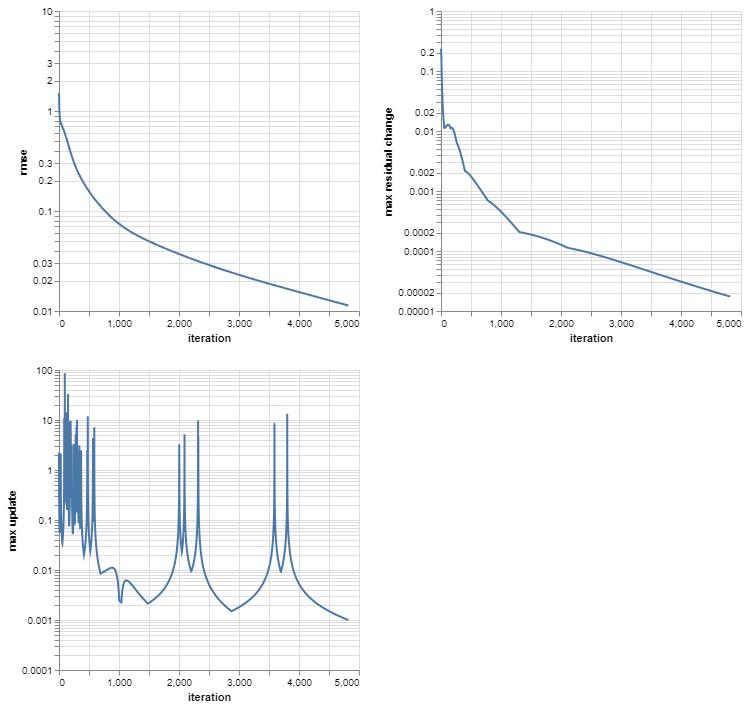

In [44]:
import altair as alt
logscale = alt.Scale(type='log', base=10)
fig_rmse = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('rmse:Q', scale=logscale)
    )
fig_max_residual_change = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max residual change:Q', scale=logscale)
    )
fig_updates = \
    alt.Chart(output1['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale=logscale)
    )
alt.vconcat(
    fig_rmse | fig_max_residual_change,
    fig_updates 
)

By referring back to the function used to calculate the quantities in each figure, describe what each figure is showing and interpret the behavior of the optimization algorithm.

**SOLUTION**

The first plot shows the RMSE of the residual matrix G over all of the iterations. It measure the average magnitude of the residuals. The higher iterations show a trend of decreasing RMSE which means that the model gets better predictions.

The second plot shows the maximum change in residual values between consecutive iterations. This change shows how much the residuals are being updated in each iteration. This plot describes how fast the algorithm converges. As the iterations increase, the max residual change tends to also decrease.

The third plot shows the max update of matrices U and V in each iteration. The magnitude of the values in this plot represent the largest change in any element of matrices U and V between consecutive iterations. The plot shows that in general, the max update decreases as iterations increase but we also notice some iterations where the max update spikes to a large number. This is most likely due to how we defined the function max_update(). The max update calculates the maximum for the relative change between each element of Unew and U as well as Vnew and V. This means that if U or V had an element very close to zero, and the Unew or Vnew had an update on that element that made it larger, we would see a very high max update value. (Unew - U) / U.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1e: Analyze Large Dataset

Following code will analyze a larger dataset:

In [17]:
# run on larger dataset
Rbig = pd.read_pickle('data/ratings_stacked.pkl').unstack()[100:]

np.random.seed(134) # set seed for tests
output3 = compute_UV(Rbig, K=5, alpha=0.001, max_iteration=500)

Rhatbig = output3['V']@output3['U'].T

/tmp/ipykernel_4323/1847306426.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ], axis=1).stack().dropna().reset_index()[['fit','observed']]


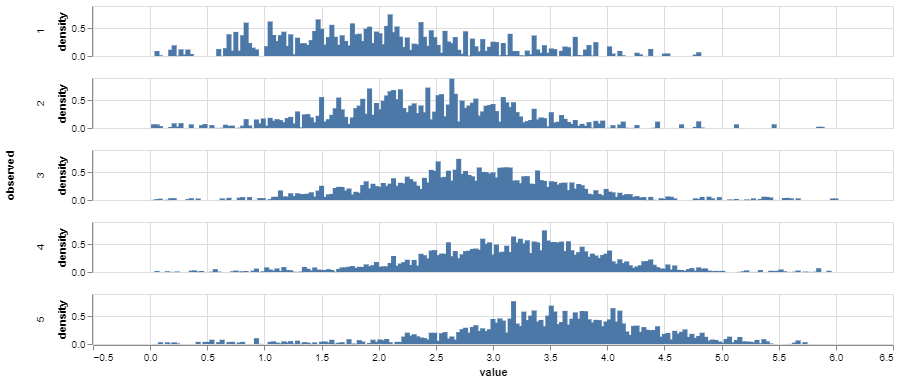

In [45]:
fit_vs_obs = pd.concat([
    Rhatbig.rename(columns={'rating':'fit'}),
    Rbig.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs = fit_vs_obs.iloc[np.random.choice(len(fit_vs_obs), 5000)]

alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

**Question**: Consider the above plot.
- By reading the code, comment on what the plot is illustrating. 
- What happens when you add `counts=True` to `transform_density`? What can you conclude?

**SOLUTION**

The code above uses altair to compute the density of fitted ratings grouped by the observed rating. For example, the third plot shows all of the movie ratings that had an observed value of 3, and it shows the density of the predicted value that the movie was given by the algorithm. Overall, we can see that the higher the observed value, the more that the distribution of ratings shifts toward higher ratings, meaning that the algorithm is working. I do notice that the observed values of 1, have a very spread out distribution which makes me believe that the algorithm is not the best at predicting lower scores. Below, I will add the counts=True to the transform_density to maybe get a better look at why this is the case.

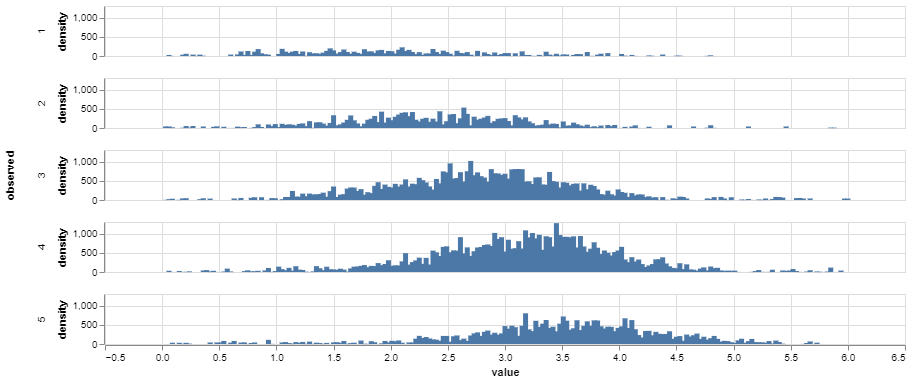

In [46]:
alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6],
    counts= True
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

By adding counts=True to transform_density(), we can see the counts for the predicted values. I notice that most of the observed values are 3s and 4s. I also notice that the counts for observed values in the 1s and 2s are much lower than the other ratings which makes me believe that the reason why the predictions for observed values of 1s is so spread out is because we do not have enough data for our algorithm to learn how to predict the lower scores. This makes sense, because the distributions of 3 and 4, which have the most data, are the least variable.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1f: Make Recommendation

What movies would you recommend to `user id` 601? Do you see any similarities to movies the user rated high?

**SOLUTION**

In [20]:
predicted_601 = Rhatbig[('rating',   601)].reset_index()
top_601_pred = predicted_601.sort_values(by=('rating', 601),ascending=False)
top_601_pred.head(10)

,movie id,movie title,rating
,,,601
71,172,"Empire Strikes Back, The (1980)",9.961383
103,204,Back to the Future (1985),7.905657
1399,1500,Santa with Muscles (1996),4.932997
67,168,Monty Python and the Holy Grail (1974),4.223360
1366,1467,"Saint of Fort Washington, The (1993)",4.016834
307,408,"Close Shave, A (1995)",3.973421
115,216,When Harry Met Sally... (1989),3.822423
382,483,Casablanca (1942),3.599893
82,183,Alien (1979),3.594180


In [21]:
user_601_ratings = Rbig[('rating',   601)].reset_index().dropna()
top_601_ratings = user_601_ratings.sort_values(by=('rating', 601),ascending=False)
top_601_ratings.head(10)

,movie id,movie title,rating
,,,601
67,168,Monty Python and the Holy Grail (1974),5.0
31,132,"Wizard of Oz, The (1939)",5.0
72,173,"Princess Bride, The (1987)",5.0
127,228,Star Trek: The Wrath of Khan (1982),5.0
78,179,"Clockwork Orange, A (1971)",5.0
80,181,Return of the Jedi (1983),5.0
53,154,Monty Python's Life of Brian (1979),5.0
100,201,Evil Dead II (1987),5.0
328,429,"Day the Earth Stood Still, The (1951)",5.0


I would recommend movies such as "The Empire Strikes Back(1980)", "Back to the Future (1985)", and "Santa with Muscles (1996)" as these have the highest predicted ratings for this user. Looking at the top 10 movies that user 601 rated and the top 10 predicted movies, I notice that a lot of them have similar genres and time periods. It seems user 601 likes movies that came out around the 80s and 90s and they enjoy genres like sci-fi, comedy, and quite possibly war.

<!-- END QUESTION -->

## Question 2: Regularization

One of the common problems in machine learning is overfitting, and a common method that remedies overfitting is regularization.

Recall that we solved the following optimization problem
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

To prevent overfitting, we can introduce $L_2$ regularization on both the user matrix and the movie matrix. Then the new optimization problem is

$$
\begin{aligned}
\min_{U,V} g(U,V) &=\min_{U,V} \|R - V U^T \|_F^2 + \lambda(\|U\|_F^2 + \|V\|_F^2)\\
&= \min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 + \lambda (\sum_{i=1}^{I}\|u_i\|_2^2 + \sum_{m=1}^{M}\|v_m\|_2^2) \right\}\\
\end{aligned}
$$
where $\lambda$ is a tuning parameter that determines the strength of regularization.

<!-- BEGIN QUESTION -->

### Question 2a: Derive New Gradients and Update Rules

Based on the new objective function $g(U,V)$, derive its gradients and update rules for $U^{\text{new}}$ and $V^{\text{new}}$.

$$
\begin{aligned}
\frac{\partial{d}}{\partial{u_i}} = -2 \sum_{m=1}^M \sum_{i=1}^I (D_{mi}\gamma_{mi})^TV + 2 \lambda U \\
\frac{\partial{d}}{\partial{v_m}} = -2 \sum_{m=1}^M \sum_{i=1}^I (D_{mi}\gamma_{mi})U  + 2 \lambda V \\
\\
U^{new} = U + 2 \alpha ((D \circ \Gamma)^TV - \lambda U ) \\
V^{new} = V + 2 \alpha ((D \circ \Gamma)U - \lambda V ) \\
\end{aligned}
$$

<!-- END QUESTION -->

### Question 2b: Implementing Updates

Implement new update functions similarly as in q1b.

In [22]:
import numpy as np
import pandas as pd

def update_G_reg(R_, U_, V_):
    
    return R_ - np.dot(V_, U_.T)

def update_U_reg(G_, U_, V_, lam, alpha=0.01):
    
    return U_ + 2 * alpha * (np.dot(np.nan_to_num(G_.T), V_) - lam * U_ )

def update_V_reg(G_, U_, V_, lam, alpha=0.01):
    
    return V_ + 2 * alpha * (np.dot(np.nan_to_num(G_), U_) - lam * V_ )

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2
lam = 5.0

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G_reg(R_, U_, V_)

In [23]:
grader.check("q2b")

q2b results: All test cases passed!

### Question 2c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

In [24]:
def compute_UV_reg(Rdf, K=5, lam=0.5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U_reg(G, U, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, V)

        Vnew = update_V_reg(Gnew, Unew, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output4 = compute_UV_reg(Rsmall, K=10, lam=0.5, alpha=0.001)

In [25]:
grader.check("q2c")

q2c results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2d: Investigating the Effects of Regularization

Adding the regularization terms to the objective function will affect the estimates of $U$ and $V$. Here, we consider comparing the user matrix $U$.

Using the dataset *Rsmall*, obtain two estimated user matrices, say $\hat{U}$ for a non-regularized model and $\hat{U}_{\text{reg}}$ for a regularized model. Select $K = 20$ and $\lambda = 5$. Come up with an effective visualization for comparing $\hat{U}$ and $\hat{U}_{\text{reg}}$, and describe any differences you notice. Additionally, analyze whether the observed differences in patterns align with the concept of regularization.

Provide reasoning supported by evidence, such as code implementation and results.

**SOLUTION**

In [26]:
np.random.seed(134) # set seed for tests
output_noreg = compute_UV(Rsmall, K=20, alpha=0.001)
output_reg = compute_UV_reg(Rsmall, K=20, lam=5.0, alpha=0.001)

In [27]:
U_noreg = output_noreg['U']
U_reg = output_reg['U']

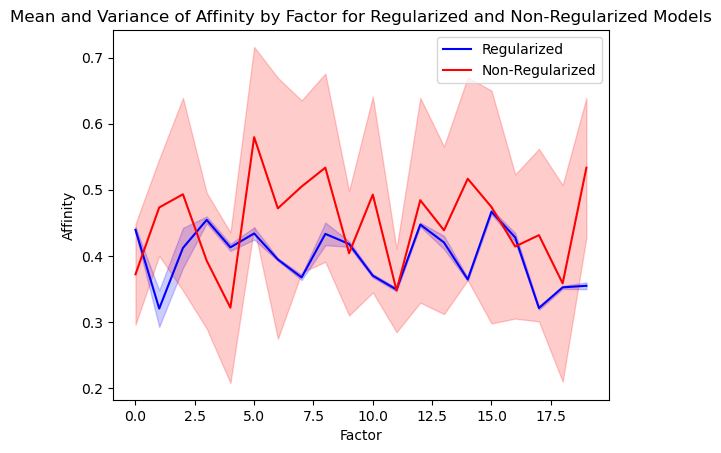

In [28]:
import matplotlib.pyplot as plt

mean_Ureg = np.mean(U_reg, axis=0)
variance_Ureg = np.var(U_reg, axis=0)
mean_Unoreg = np.mean(U_noreg, axis=0)
variance_Unoreg = np.var(U_noreg, axis=0)

# Define the number of factors K
num_factors = len(mean_Ureg)

# Create an array of indices representing factors K
factor_indices = np.arange(num_factors)

# Plot the mean per factor for Ureg
plt.plot(factor_indices, mean_Ureg, label='Regularized', color='blue')

# Plot the variance per movie for Ureg as a shaded region
plt.fill_between(factor_indices, mean_Ureg - variance_Ureg, mean_Ureg + variance_Ureg, alpha=0.2, color='blue')

# Plot the mean per factor for Unoreg
plt.plot(factor_indices, mean_Unoreg, label='Non-Regularized', color='red')

# Plot the variance per movie for Unoreg as a shaded region
plt.fill_between(factor_indices, mean_Unoreg - variance_Unoreg, mean_Unoreg + variance_Unoreg, alpha=0.2, color='red')

# Add labels and legend
plt.xlabel('Factor')
plt.ylabel('Affinity')
plt.title('Mean and Variance of Affinity by Factor for Regularized and Non-Regularized Models')
plt.legend()

# Show plot
plt.show()

After exploring the data and testing different plots, I noticed that the regularized Matrix had a much lower variance than the non-regularized matrix when comparing the user information. Each row of the U_hat matrix represents a user, each column represents a latent factor, and the values represent the affinity of each user towards those factors. The regularization aims to prevent overfitting by putting a constraint on the parameter values. This plot above effectively shows that the regularized version has a reduction of variance and that it leads to more balanced estimates. None of the estimates are too extreme for any given factor.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e: Practical Aspects

In the previous question, a specific values for $K$ and $\lambda$ were provided. Now, try applying various $K$'s and $\lambda$'s. Specifically, try the following:

 - While keeping $K$ constant, experiment with different values of $\lambda$. What do you notice? Why do you think this happens?
 - While keeping $\lambda$ constant, experiment with different values of $K$. What do you notice? Why do you think this happens?

If your optimization algorithm is correctly implemented, you will notice that the choice of $K$ and $\lambda$ has a significant impact on the final estimates. Hence, selecting appropriate values for $K$ and $\lambda$ is crucial when applying the recommendation algorithm in practice. As a practitioner, how would you approach choosing $K$ and $\lambda$?

Provide reasoning supported **by evidence**, such as code implementation and results.

**SOLUTION**

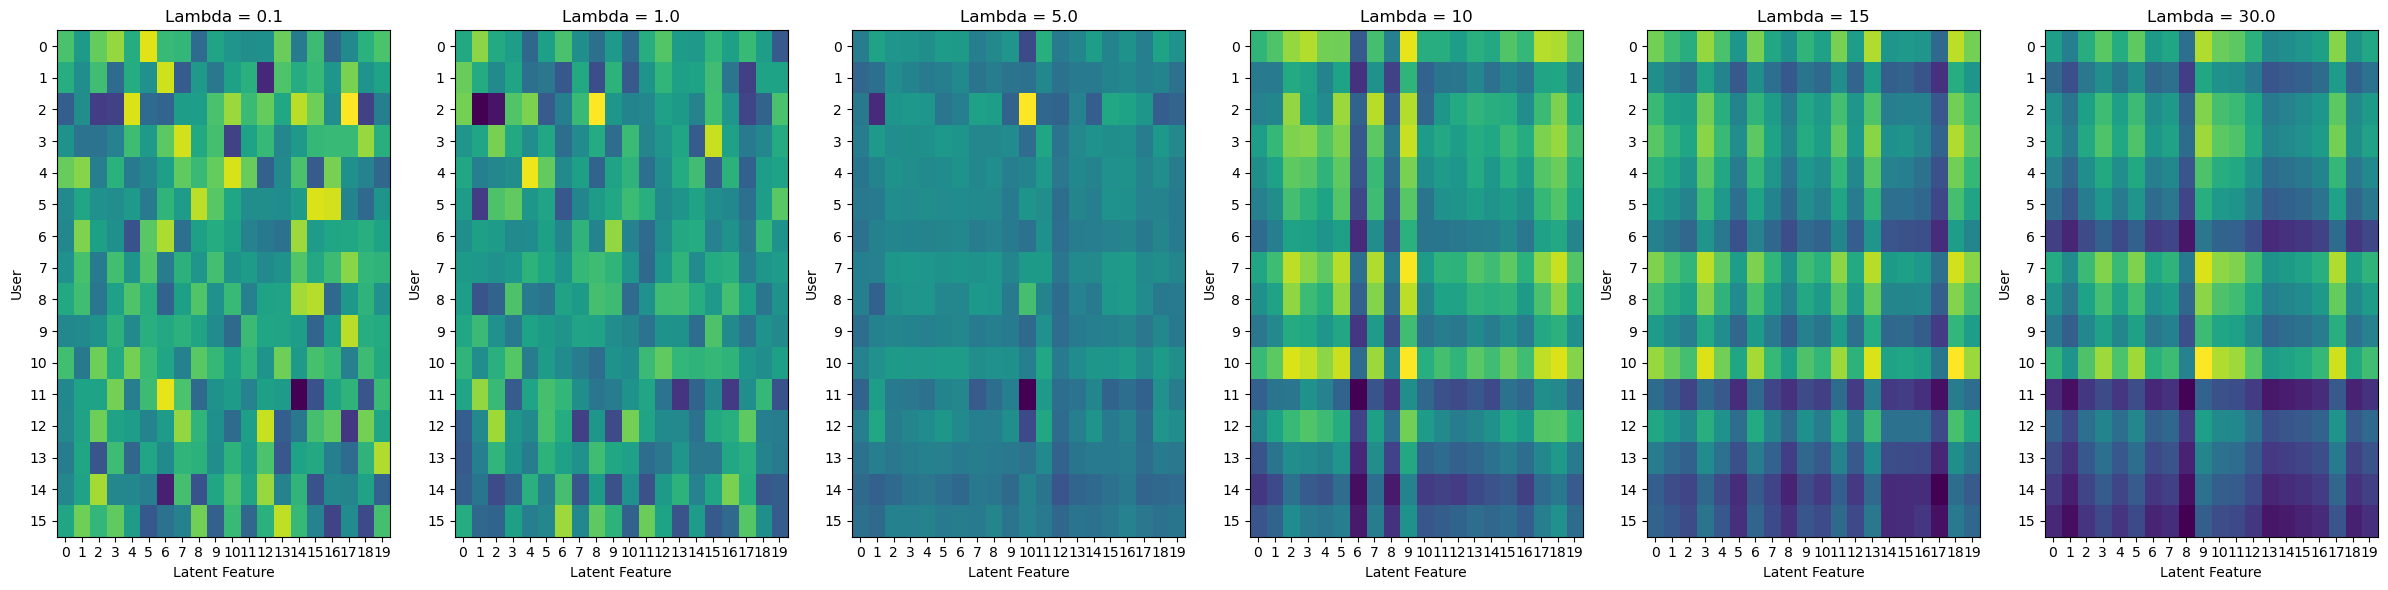

In [29]:
np.random.seed(134)
#Constant K, varying Lambda
K = 20  # Constant value of K
lambdas = [0.1, 1.0, 5.0, 10, 15, 30.0]  # Different values of lambda to try

results_lambda = {}  # Dictionary to store results for different lambdas

for lam in lambdas:
    output_reg_lambda = compute_UV_reg(Rsmall, K=K, lam=lam, alpha=0.001)
    results_lambda[lam] = output_reg_lambda['U']

fig, axs = plt.subplots(1, len(lambdas), figsize=(len(lambdas) * 4, len(lambdas)))

for i, lam in enumerate(lambdas):
    ax = axs[i]
    ax.imshow(results_lambda[lam], cmap='viridis', aspect='auto')
    ax.set_title(f'Lambda = {lam}')
    ax.set_xlabel('Latent Feature')
    ax.set_ylabel('User')
    ax.set_xticks(range(K))
    ax.set_yticks(range(len(results_lambda[lam])))
    ax.grid(False)

plt.tight_layout()
plt.show()

The plots above show the U_hat matrices values in color (Note: The colors are with respect to its own values in the heatmap). I notice with these plots that the lower lambda values cause more 'randomness' in the colors on the heat map while the higher values for lambda start to form a pattern. Looking at the data, we can see that all of the values in the U matrix when lambda is equal to 30, are basically the same values. This means that the higher the value for lambda, the more standardized the values get until eventually, they are all equal.

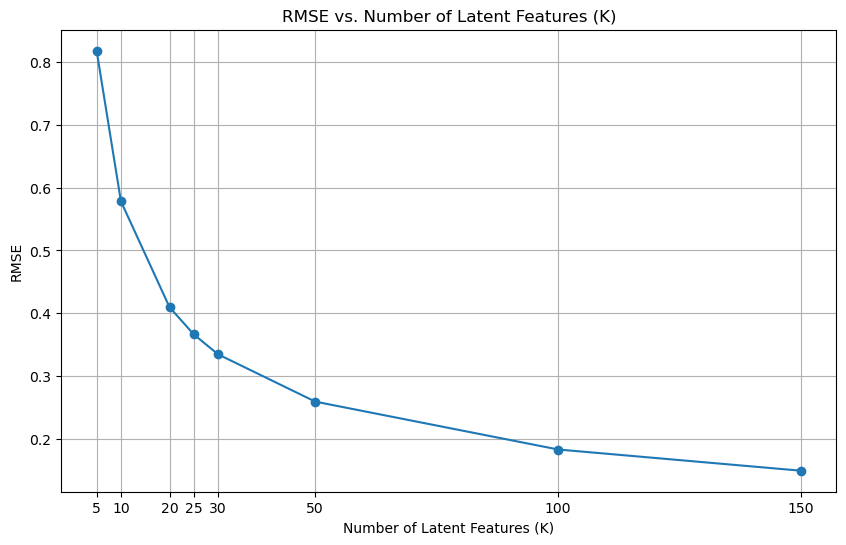

In [30]:
np.random.seed(134)
#Constant Lambda, varying K
lambda_val = 5.0  # Constant value of lambda
K_values = [5, 10, 20, 25, 30, 50, 100, 150]  # Different values of K to try

results_K = {}  # Dictionary to store results for different K values


for K_val in K_values:
    output_reg_K = compute_UV_reg(Rsmall, K=K_val, lam=lambda_val, alpha=0.001)
    results_K[K_val] = output_reg_K['U']

K_values = list(results_K.keys())
rmse_values = [rmse(results_K[K]) for K in K_values]

# Plot the results for Experiment 2: Varying K with constant lambda
plt.figure(figsize=(10, 6))
plt.plot(K_values, rmse_values, marker='o')
plt.title('RMSE vs. Number of Latent Features (K)')
plt.xlabel('Number of Latent Features (K)')
plt.ylabel('RMSE')
plt.xticks(K_values)
plt.grid(True)
plt.show()

This plot shows the RMSE of the model when we change the Number of Latent Features K while keeping lambda constant. As we can see, the higher number of features leads to a decrease in RMSE. This is not necessarily a good thing as a very low RMSE could be a sign of the model overfitting the data. Increasing the K value should decrease the RMSE because it increases the model complexity which makes it so the model can fit the data better. Again, this can be a bad thing because if the model is overfitting the data, then it will not be able to predict new data as well.

As a practitioner, to approach choosing K and lambda, I would first start with a reasonable range of K and Lambda in the context of the problem by testing a range of each of these variables. The two experiments above are a good way to visualize the effect of these values on the model. There are many things to consider when testing these values such as the bias and the variance of the model. I would also check how well the model fits new data by using methods such as cross-validation. For Our specific model, I think going with K=25 and lambda=10 is our best bet.

<!-- END QUESTION -->

## Question 3: Segmentation in Latent Factor Space

Now that we have user matrix $U$ and movie matrix $V$, suppose we want to use the newly learned representation for an advertising campaign. 

Suppose you are leading the planning of an online advertising campaign and you have a fixed budget. With the budget, you can create 5 variations of an ad, and you want to create the variations based on a representative movie each group likes.

The advertisements will entice the viewer to sign up for a mailing list by offering a free poster. The goal of the advertising campaign is two fold: 

1. Get potential customers to sign up using their email address by offering a free poster among the 5 "representative" movies
2. Learn their user segment placement preference to use for the starting point for movie recommendations once they sign up

In order to achieve this goal, we want to 
1. Produce clusterings of users
2. Balance performance metric of clustering results and practical considerations to choose one of the clustering results.

We will tackle this step by step.

<!-- BEGIN QUESTION -->

### Question 3a: Concatenate matrix factors and cluster

Entries in either matrix factors are just points in $k$-dimensional latent variable space. We will use both $U$ and $V$ for segmentation by combining them into one large clustering problem.

Once clusters are identified, you will qualitatively inspect the users and movies in the cluster and decide on a "representative" movie from each cluster.

Consider concatenating $U$ and $V$ into one large matrix. Since these matrices have arbitrary scaling, it would be a good idea to standardize the columns before concatenating them. Standardize $U$ and $V$ separately, then concatenate with numpy's `concatenate` method. Call this concatenated matrix, `UVstd`.

Apply hierarchical and K-means clustering methods on `UVstd`.  For each clustering method, identify 5 clusters. Compare the clustering results by applying three different [cluster validation metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the clustering performance. 

Which cluster performance metrics can you use? Do we have true labels? Does one performance metric seem to clearly be better than another? Why would you choose one metric over another? What interpretation, if any, does each metric have in the context of our problem? Explain.

Note: In this part, 
- Creating a new data `Rmedium` by `ratings_stacked.pkl` and `Rsmall`,
    1. Loading `rantings_stacked.pkl` and adding the `user id` having less than 134 NA's in it to `user id` in `Rsmall`,
    2. Adding movies with `movie id` $134-234$ to `movie id` in `Rsmall`,
    3. Name the new dataset as `Rmedium` and use `Rmedium` to do clustering.
- Using the 'best' model you select in Question 2e to compute `UVstd`.

**SOLUTION**

In [31]:
np.random.seed(134) # set seed for tests

#First, initialize the data 
ratings_stacked = pd.read_pickle('data/ratings_stacked.pkl').unstack()

#check to see which users have the highest number of movies watched
ratings_stacked.isnull().mean().sort_values(ascending=False)
# There is no user with less than 134 NAs in ratings_stacked.pkl
# Instead, I will find the top 234 most watched movies
top_movies_index = ratings_stacked.isnull().mean(axis=1).sort_values()[0:234].index
movie_ind = []
for i in top_movies_index:
    movie_ind.append(i[0] - 1)
movie_ind

topmovielist = ratings_stacked.iloc[movie_ind]

user_ids_to_add = topmovielist.isnull().sum(axis=0) < 134

ratings = topmovielist.loc[:, user_ids_to_add]
Rmedium = pd.concat([Rsmall, ratings])
Rmedium

Output = compute_UV_reg(Rmedium, K=25, lam=10, alpha=0.001)

In [32]:
U = Output['U']
V = Output['V']

# Standardize the columns of U
U_standardized = (U - U.mean(axis=0)) / U.std(axis=0)

# Standardize the columns of V
V_standardized = (V - V.mean(axis=0)) / V.std(axis=0)

UVstd = np.concatenate((U_standardized, V_standardized), axis=0)

In [33]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

# Standardize the concatenated matrix UVstd
scaler = StandardScaler()
UVstd_scaled = scaler.fit_transform(UVstd)

# Apply hierarchical clustering
hierarchical_cluster = AgglomerativeClustering(n_clusters=5)
hierarchical_labels = hierarchical_cluster.fit_predict(UVstd_scaled)

# Apply K-means clustering
kmeans_cluster = KMeans(n_clusters=5, random_state=123)
kmeans_labels = kmeans_cluster.fit_predict(UVstd_scaled)

# Compute cluster validation metrics
silhouette_hierarchical = silhouette_score(UVstd_scaled, hierarchical_labels)
silhouette_kmeans = silhouette_score(UVstd_scaled, kmeans_labels)

davies_bouldin_hierarchical = davies_bouldin_score(UVstd_scaled, hierarchical_labels)
davies_bouldin_kmeans = davies_bouldin_score(UVstd_scaled, kmeans_labels)

calinski_harabasz_hierarchical = calinski_harabasz_score(UVstd_scaled, hierarchical_labels)
calinski_harabasz_kmeans = calinski_harabasz_score(UVstd_scaled, kmeans_labels)

# Print the cluster validation metrics
print("Hierarchical Clustering:")
print("Silhouette Score:", silhouette_hierarchical)
print("Davies-Bouldin Index:", davies_bouldin_hierarchical)
print("Calinski-Harabasz Index:", calinski_harabasz_hierarchical)
print("\n")

print("K-means Clustering:")
print("Silhouette Score:", silhouette_kmeans)
print("Davies-Bouldin Index:", davies_bouldin_kmeans)
print("Calinski-Harabasz Index:", calinski_harabasz_kmeans)

Hierarchical Clustering:
Silhouette Score: 0.028625030737073374
Davies-Bouldin Index: 3.9808611948243198
Calinski-Harabasz Index: 15.955978228784202


K-means Clustering:
Silhouette Score: 0.05163586743752417
Davies-Bouldin Index: 3.1124238416918115
Calinski-Harabasz Index: 19.41920676438854


In our data, we do not have true labels for the users and movies, which means we are only able to evaluate the clustering results using intrinsic cluster validation metrics such as the ones above. (Silhouette score, Davies-Bouldin index, and Calinski-Harabasz Index). Lets start with Silhouette Score; for Hierarchical Clustering, we obtain a silhouette score of 0.0286 and for K-means 0.051. Silhouette score is bound between -1 and 1, with a higher score meaning clusters are denser and more separated. Scores near 0 indicate overlapping clusters and since both of these scores are very close to 0, this means that the clusters are either more spread out or overlapping. In the context of our problem, a high silhouette score suggests that the clusters are well-defined and distinct from each other, indicating clear separation of user preferences for movies. 
The second evaluation we used is the Davies-Bouldin index where the best values are closer to 0 meaning there is better partitioning. We can see from our evaluations that the scores are 3.9 and 3.1 which means that they performed fairly similarly but the K-means clustering was lower. In the context of our problem, a lower Davies-Bouldin index suggests that the clusters more accurately capture the underlying structure of user preferences for movies, with clear boundaries between different clusters.
The third evaluation I tested was the Calinski-Harabasz Index. The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared). In this evaluation, the score is higher when the clusters are denser and well separated. Looking at the scores above, we can see that the K-Means clustering performs better yet again. A higher Calinski-Harabasz index suggests that the clusters represent meaningful groupings of user preferences, with clear distinctions between different clusters. Overall, the K-means clustering seems to perform better for this model. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b: Visualizing Clusters in Latent Space

Select the clustering method based on the evaluation results in q3a and visualize the clusters using [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html). Are the clusters and UMAP projection consistent?

**SOLUTION**

In [34]:
# install umap
# !pip install umap-learn

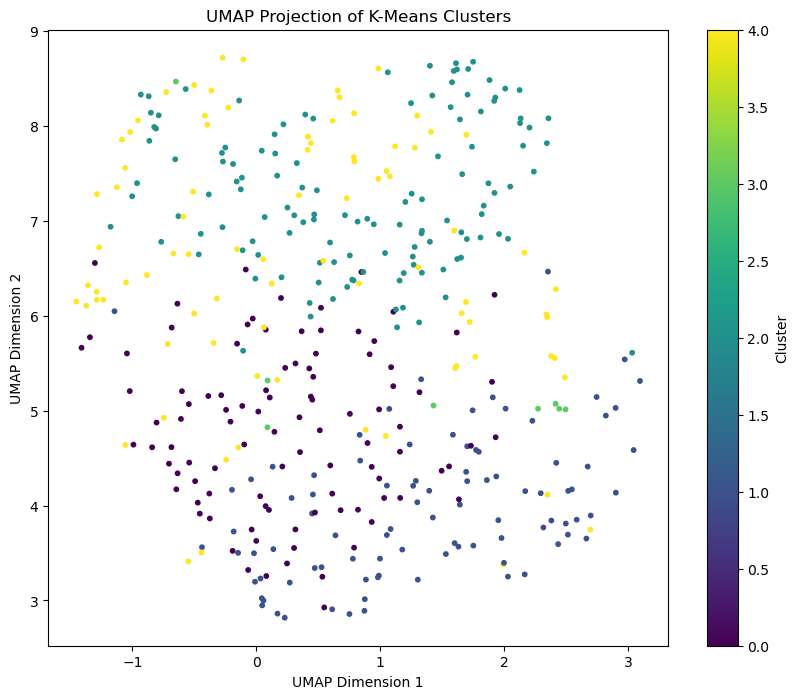

In [35]:
import umap


# Reduce dimensionality using UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(UVstd)

# Plot UMAP projection colored by cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title('UMAP Projection of K-Means Clusters')
plt.colorbar(label='Cluster')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

Looking at the Umap projection above, we notice a decent amount of points that seem inconsistent with the clusters. For example, the purple cluster seems to be the least consistent having points on the fair sides of almost all clusters. All of the clusters are decently spread out which does make sense from our evaluations from before and we can notice the general areas that the clusters are in.

<!-- END QUESTION -->

_Cell Intentionally Blank_

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Download the zip file and submit to Gradescope.

In [42]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1b results: All test cases passed!

    q1c results: All test cases passed!

    q2b results: All test cases passed!

    q2c results: All test cases passed!
